# Log linear Model 

$\textit{Charles Rollet, Alexandre Partensky et Corentin Pernot } $ 

Les Log-linear models s'appliquent à un vecteur prenant ses valeurs dans $\{0,1\}^d$.
La probabilité d'observer un certian x est telle que (pour un modèle restraint à un ordre 2 d'intéractions) :

> ##### $ \log P(X=x) = \alpha + \sum_{i=1}^n \beta_i x_i + \sum_{i<j}^n \gamma_{ij} x_i x_j$ 


- La question 1. s'intéresse à générer des données à partir des paramètres $\beta$ et $\gamma$ fixés. 
- Les questions suivantes, quant à elles, s'intéressent au fait de remonter aux paramètres étant donnée une distribution. 


Sources: 
> $\textit{ Cours de Monte Carlo, N.Chopin}$

> $\textit{ MCMC for doubly-intractable distributions, I.Murray Z.Ghahramani D.J.C.MacKay}$ 
https://mlg.eng.cam.ac.uk/zoubin/papers/doubly_intractable.pdf

> $\textit{Computational Statistics, T. Donœux} $   
 https://www.hds.utc.fr/~tdenoeux/dokuwiki/_media/en/mcmc_slides.pdf  


In [1]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.stats import chi2

# Question 1 

### Propose and implement an algorithm to sample data from this model (for fixed values of βi). How can you check that the corresponding algorithm mixes well in this case?

Pour cette première question nous avons proposé 2 approches : 
> - une approche naïve en utilisant la méthode d'inversion
> - une autre approche utilisant l'algorithme de Metropoolis Hastings

Dans un premier temps nous simulons les données avec chacune des deux méthodes. 
Dans un deuxième temps nous testons si cette simulation est correcte étant données $ \beta = ( \beta _0, \beta _1, ...,\beta _{d-1})  $ et $ \gamma = (\gamma _{01} ,..., \gamma _{0d-1},\gamma _{12} ,..., \gamma _{1d-1},...) $ où $d$ est la dimension. 

Par exemple en dimension 2 nous aurons :

- $ \beta = ( \beta _0, \beta _1)$
- $ \gamma = (\gamma _{01})$

Alors qu'en dimension 3 nous aurons :
- $ \beta = ( \beta _0, \beta _1, \beta _2)$
- $ \gamma = (\gamma _{01}, \gamma _{02}, \gamma _{12})$

## Méthode Inversion 

In [2]:
# Transformation d'une liste en nombre binaire 
# L'objectif est de convertir [1,0] en 2 et [1,1,1] en 7 

def binary_transf(liste):
    string = ''.join(str(int(i)) for i in liste) # Convertir la liste en une chaîne de caractères binaire
    return int(string, 2)  # Convertir la chaîne de caractères binaire en un nombre entier en base 2

In [3]:
# Pour chacun des états x, on va calculer P(X=x)

def proba_theorique(beta, d, gamma):
    "fonction qui va renvoyer les probas théoriques pour chacun des états"
    nb_states= 2**d # il ya 2**d états possibles 
    probs = np.zeros(nb_states)
    for i in range(nb_states): # on parcourt tous les états possibles
        xi = np.array([int(b) for b in np.binary_repr(i, width=d)]) 
        pairwise_terms = np.array([gamma[i][j]*xi[i]*xi[j] for i in range(d) for j in range(i+1,d)])
        linear_terms = np.array(beta).dot(xi)
        probs[i] = np.exp(linear_terms + np.sum(pairwise_terms))
    alpha = - np.log(np.sum(probs)) # on normalise pour obtenir des probas 
    probs = probs * np.exp(alpha)
    
    return (probs)

In [4]:
# Cette fonction renvoie un échantillon sous la forme [1,0] (i.e. d'un vecteur dans R_d) si binary_form = False et renvoie un entier correspondant au nombre binaire associé si binary_form = True
# On utilise la méthode par inversion vue dans le cours

def log_linear_model_sample(beta, d, gamma, binary_form):
    "fonction qui va renvoyer un état en fonction de sa proba"

    probs = proba_theorique(beta, d, gamma) # on stocke toutes les probabilités

    
    u = np.random.rand() # on tire une uniforme dans [0, 1]
    i=0
    proba_cum=probs[i]
    while u>proba_cum:
        i+=1
        proba_cum+=probs[i]

    if binary_form==True:
        return(i)
    
    else : 
        return([int(b) for b in np.binary_repr(i, width=d)])


In [5]:
# On réitère n fois le processus précédent pour obtenir un échantillon de taille n 

def generate_data( beta, d, gamma,n, binary_form):
    Sample_X=[]
    for i in range(n):
        Sample_X.append(log_linear_model_sample( beta, d, gamma,binary_form))
    return(Sample_X)


In [6]:
# Cette fonction va permettre d'afficher la distribution des états 

def display_distrib(samples,d, string):
    df=pd.DataFrame(samples, columns=['state_nb'])

    empirical_distrib = list(df.groupby(by='state_nb')['state_nb'].count())


    fig, ax = plt.subplots(figsize=(6,4))
    rects1= ax.bar([i for i in range(2**d)], empirical_distrib
                    ,color='royalblue', edgecolor = "black")
    plt.title('Répartition des états avec '+ string)
    plt.legend(loc='best')
    plt.xlabel("État") 
    plt.ylabel("Count")
    plt.grid()

# Vérification de l'algorithme

On va afficher la distribution empirique obtenue grâce à notre algorithme ainsi que la distribution théorique en utilisant les probabilités théoriques. 

In [724]:
beta = [0.5,-0.3]
d = 2
gamma = [[10,0.8],[5,1]]
n=10000

samples= np.array(generate_data( beta, d, gamma,n,True))
df=pd.DataFrame(samples, columns=['state_nb'])

In [725]:
empirical_distrib = list(df.groupby(by='state_nb')['state_nb'].count()/n)
theorical_distrib = proba_theorique(beta, d, gamma)
print(empirical_distrib)
print(theorical_distrib)

[0.1614, 0.1177, 0.267, 0.4539]
[0.1637245  0.12129009 0.26993607 0.44504934]


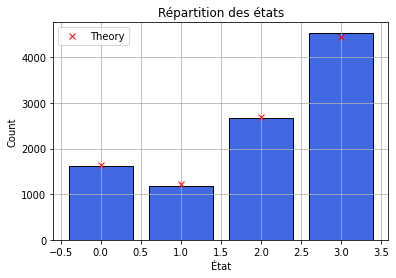

In [726]:
empirical_distrib = list(df.groupby(by='state_nb')['state_nb'].count())
theorical_distrib = proba_theorique(beta, d, gamma)*n 


fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.bar([i for i in range(2**d)], empirical_distrib
                ,color='royalblue', edgecolor = "black")
rects2= ax.plot([i for i in range(2**d)], theorical_distrib
                ,'rx' , label= 'Theory')
#plt.legend('Revenue', 'Budget')
plt.title('Répartition des états')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()
plt.show()

# Test du $\chi^2$

On réalise un test du chi 2 pour tester si les distributions coincident. 

L'hypothèse nulle $H_0$ du test du $\chi^2$ est " les distributions sont les mêmes". Le but est de ne "pas rejeter" cette hypothèse même si on aurait préféré rejeter l'autre hypothèse "les distributions sont différentes". 

In [732]:
samples= np.array(generate_data( beta, d, gamma,n, binary_form=True))
df=pd.DataFrame(samples, columns=['state_nb'])

In [733]:
empirical_distrib = np.array(list(df.groupby(by='state_nb')['state_nb'].count()/n))
theorical_distrib = np.array(list(proba_theorique(beta, d, gamma)))

In [734]:
print(empirical_distrib)
print(theorical_distrib)

[0.1646 0.1225 0.2635 0.4494]
[0.1637245  0.12129009 0.26993607 0.44504934]


In [735]:
# Calcul de la statistique du test du chi carré
chi2_stat = n *np.sum((empirical_distrib - theorical_distrib)**2 / theorical_distrib) #on doit mettre un facteur n (qui correspond au nb d'observations)

# Calcul de la valeur p
df = len(empirical_distrib) - 1 #degrés de liberté 
chi2_dist = chi2(df) #loi du chi_2 à df degrés de liberté 
p = 1 - chi2_dist.cdf(chi2_stat) 
#p est égal à la proba d'obtenir une différence aussi extrême ou plus extrême que celle observée 
#entre les fréquences observées et les fréquences théoriques,
#sous l'hypothèse nulle que les fréquences observées sont égales aux fréquences théoriques.

# Affichage des résultats
print("Statistique du test du chi carré : ", chi2_stat)
print("Valeur p : ", p)

Statistique du test du chi carré :  2.1273628670757025
Valeur p :  0.546396934702519


Ok, la p-valeur est grande (>0.1) ainsi on ne peut pas rejeter l'hypothèse nulle qui correspond au fait que les fréquences observées dans un échantillon sont égales aux fréquences théoriques attendues. 

Ainsi, la distribution empirique matche avec la distribution théorique.

# Méthode Métropolis-Hastings

> Contrairement à notre méthode naïve, $ \textbf{où l'on calcule la constante de normalisation ainsi que les probabilités pour chacun des états}$ , l'algorithme de Métropolis Hastings ne nécessite pas un tel calcul. 

In [7]:
def log_f(x, beta, gamma):
    " On calcule la log-proba sans faire intervenir la constante de normalisation "
    " pour un vecteur fixé étant donnés les paramètres (on n'a pas besoin de alpha puisqu'on utilise un rapport dans l'algo M-H)"
    d = len(x)
    pairwise = sum(gamma[i][j] * x[i] * x[j] for i in range(d) for j in range(i+1, d))
    return sum(beta[i] * x[i] for i in range(d)) + pairwise

def proba_non_normalisée(x,beta,gamma):
    return(np.exp(log_f(x, beta, gamma)))


def metropolis_hastings_avec_iter(beta, gamma, initial_state,nb_iter, n, binary_form, plot_acceptance_rate):
    "On génère n samples avec le log-linear model en utilisant l'algo de Metropolis Hastings"
    " plot_acceptance_rate est True ou False " 
    " comme dans la méthode naïve binary_form= False renvoie un vecteur dans R_d tandis que binary_form = True renvoie un entier "
    d=len(beta)
    samples = np.zeros((n, d)) #vecteurs de 0 
    current_state = initial_state #état initial
    acceptance_rate_moyen=[]

    for i in range(n): #pour chacun des vecteurs 
        acceptance_rate=0
        for t in range(nb_iter):
            j = np.random.randint(0, len(beta)) # on change une composante au hasard, np.random.randint: il s'agit du q de l'article 
            x_proposed = np.copy(current_state)
            x_proposed[j] = 1 - x_proposed[j]
            new_state = np.copy(current_state)
            new_state[j] = 1 - current_state[j] # on propose un nouvel état en modifiant la j-ième composante
            a = log_f(new_state, beta, gamma) - log_f(current_state, beta, gamma) # on calcule le rapport des probabilités entre le nouvel état et l'ancien état
            a = min(1, np.exp(a)) # car q(x|x')= q(x'|x)
            acceptance_rate+=a
            if np.random.uniform() < a: # on fait le choix d'accepter ou de rejeter 
                current_state = new_state
        acceptance_rate_moyen.append(acceptance_rate/nb_iter)
        samples[i] = current_state
        
    if binary_form==True:
        samples= [binary_transf(i) for i in samples]

    if plot_acceptance_rate == True : 
        fig, ax = plt.subplots(figsize=(6,4))
        rects1= ax.plot([i for i in range(n)], acceptance_rate_moyen
                        ,'rx')
        plt.title('Acceptance Rate avec Metropolis - Hastings pour les 10 itérations')
        plt.legend(loc='best')
        plt.xlabel("Nombre d'échantillons") 
        plt.ylabel("Acceptance Rate Moyen ")
        plt.grid()
        
       
    return samples 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


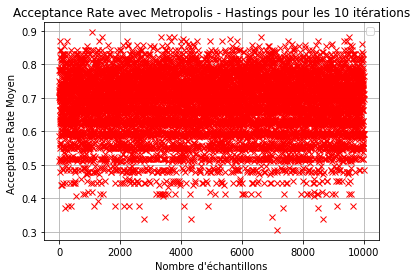

In [737]:
beta = [0.5,-0.3]
d = 2
gamma = [[10,0.8],[5,1]]
n=10000
n_iter=10

x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples = metropolis_hastings_avec_iter(beta, gamma, x0, n_iter, n, True, True)

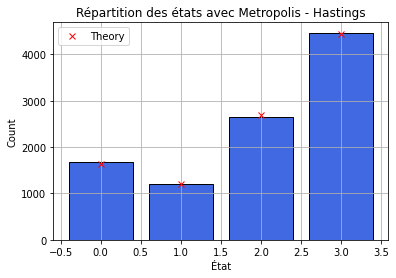

In [738]:
df=pd.DataFrame(samples, columns=['state_nb'])

empirical_distrib = list(df.groupby(by='state_nb')['state_nb'].count())
theorical_distrib = proba_theorique(beta, d, gamma)*n 


fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.bar([i for i in range(2**d)], empirical_distrib
                ,color='royalblue', edgecolor = "black")
rects2= ax.plot([i for i in range(2**d)], theorical_distrib
                ,'rx' , label= 'Theory')
#plt.legend('Revenue', 'Budget')
plt.title('Répartition des états avec Metropolis - Hastings')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()
plt.show()

In [739]:
empirical_distrib = np.array(list(df.groupby(by='state_nb')['state_nb'].count()/n))
theorical_distrib = np.array(list(proba_theorique(beta, d, gamma)))

# Calcul de la statistique du test du chi carré
chi2_stat = n *np.sum((empirical_distrib - theorical_distrib)**2 / theorical_distrib) #on doit mettre un facteur n (qui correspond au nb d'observations)

# Calcul de la valeur p
df = len(empirical_distrib) - 1 #degrés de liberté 
chi2_dist = chi2(df) #loi du chi_2 à df degrés de liberté 
p = 1 - chi2_dist.cdf(chi2_stat) 
#p est égal à la proba d'obtenir une différence aussi extrême ou plus extrême que celle observée 
#entre les fréquences observées et les fréquences théoriques,
#sous l'hypothèse nulle que les fréquences observées sont égales aux fréquences théoriques.

# Affichage des résultats
print("Statistique du test du chi carré : ", chi2_stat)
print("Valeur p : ", p)

Statistique du test du chi carré :  2.261840830964366
Valeur p :  0.5198705798729177


## On vérifie si l'algorithm "mixes well"

Pour vérifier que l'algorithme "mixes well", on décide d'afficher les autocorrelation des samples pour chacune des coordonnées séparrément. Si les pics décroissent rapidement avec les lags, alors l'algorithm "mixes well".

Si le maximim des autocorrélations pour chacune des coordonnées est petit (par exemple moins de 0.1), alors l'algorithme 'mixes well'. En revanche, si l'autocorrélation est importante, on devra augmenter le nombre d'itérations dans l'algorithme de Metropolis - Hastings. 

On vérifie ici que l'algorithme explore bien toutes les états possibles. Cela correspond au fait que les états tirés ne sont pas corrélés avec les états tirés précédemment. 

In [18]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [19]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [740]:
def acf_plot(x,lags):
    fig, axes = plt.subplots(ncols=2, figsize=(12,4))
    for i, ax in enumerate(axes.flat):
        plot_acf(x[:,i], ax=ax, lags=lags)
        ax.grid()
        ax.set_title('Variable {}'.format(i+1))
        ax.set_xlabel('Lags'.format(i+1))
        ax.set_ylabel('ACF'.format(i+1))
    plt.tight_layout()

## État par état 

In [743]:
beta = [0.5,-0.3]
d = 2
gamma = [[10,0.8],[5,1]]
n=1000
n_iter=10

x0 = np.zeros(len(beta), dtype=int)  # start from all zeros

samples_1 = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 1, n, True, False)) # uniquement 1 itération 
samples_2 = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 3, n, True, False)) # 3 itérations
samples_3 = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 10, n, True, False)) # 10 itérations

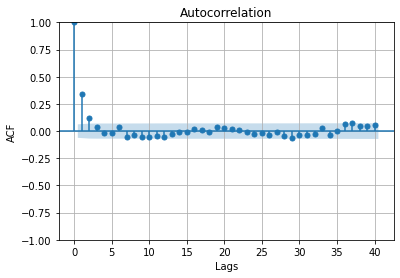

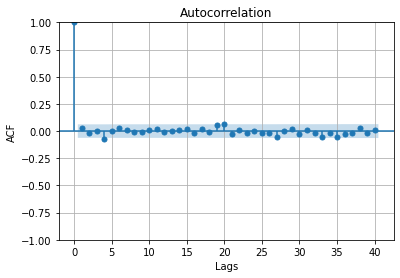

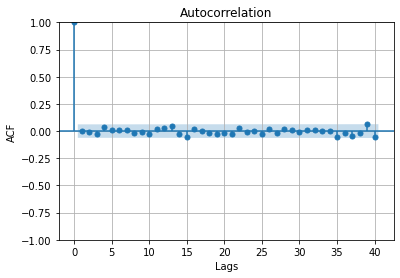

In [744]:
for i in [samples_1,samples_2, samples_3]:
    plot_acf(i, lags=40)
    plt.grid()
    plt.xlabel('Lags')
    plt.ylabel('ACF') 

## Variable par variable

In [749]:
beta = [0.5,-0.3]
d = 2
gamma = [[10,0.8],[5,1]]
n=1000
n_iter=10

x0 = np.zeros(len(beta), dtype=int)  # start from all zeros

samples_1 = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 1, n, False, False)) # uniquement 1 itération 
samples_2 = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 3, n, False, False)) # 3 itérations
samples_3 = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 10, n, False, False)) # 10 itérations

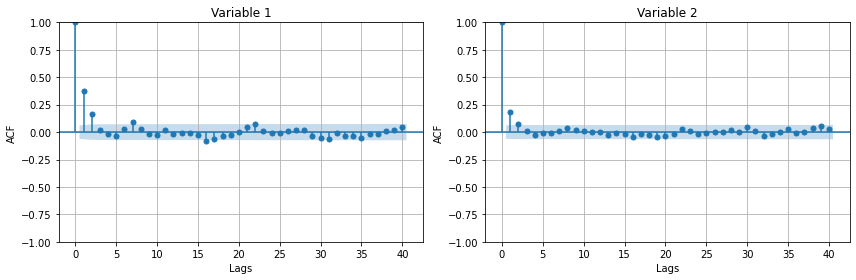

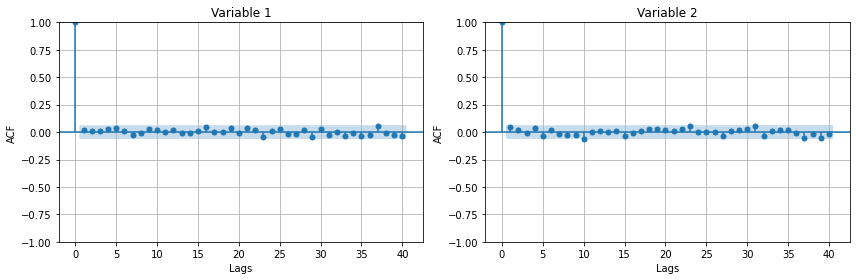

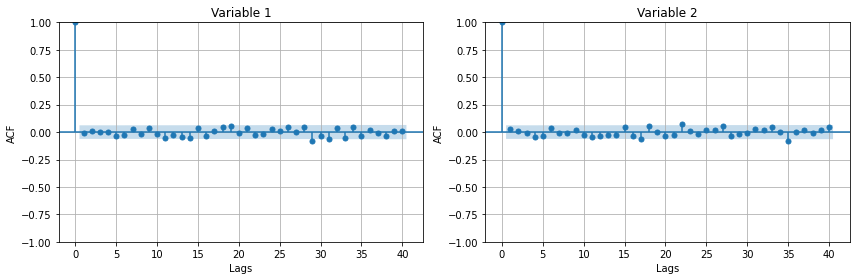

In [750]:
acf_plot(samples_1,40)
acf_plot(samples_2,40)
acf_plot(samples_3,40)

## Comparaison Inversion / Metropolis Hastings 

On va comparer le temps d'exécution des deux algorithmes. 

On s'attend à ce que le temps d'éxecution de la méthode d'inversion explose avec la dimension puisqu'elle nécessite le calcul de $2^d$ états. 

In [27]:
import time

In [28]:
i=2        
beta = np.random.normal(size=i)
gamma = np.zeros((i, i))
for k in range(d):
    for j in range(k+1, d):
        gamma[k][j] = np.random.normal()
        gamma[j][k] = gamma[k][j]
gamma

array([[ 0.        , -0.41934594],
       [-0.41934594,  0.        ]])

In [22]:
from tqdm import tqdm

## Mesure du temps d'exécution en fonction de la dimension 

In [30]:

beta = [2,1]
d = 2
gamma = [[10,-1],[5,1]]

def test_du_temps(d,n): 
    D=[i for i in range(2,d+1)]
    time_MH=[]
    time_inversion=[]
    for i in tqdm(range(2,d+1)):

        beta = np.random.normal(size=i)
        gamma = np.zeros((i, i))
        for k in range(i):
            for j in range(k+1, i):
                gamma[k][j] = np.random.normal()
                gamma[j][k] = gamma[k][j]

        # Méthode d'inversion
        start_time = time.time()
        x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
        samples= np.array(generate_data( beta, i, gamma,n, True))
        end_time = time.time()

        duree_execution = end_time - start_time
        time_inversion.append(duree_execution)
        #print(duree_execution)

        # Metropolis Hastings 
        start_time = time.time()
        x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
        samples_MH = np.array(metropolis_hastings_avec_iter(beta, gamma, x0, 10, n,True,False))
        end_time = time.time()
        duree_execution = end_time - start_time
        time_MH.append(duree_execution)
        #print(duree_execution)

    fig, ax = plt.subplots(figsize=(12,10))
    rects1= ax.plot(D, time_MH
                ,'bo--', label='Metropolis Hastings')
    rects2= ax.plot(D, time_inversion
                ,'ro--' , label= 'Inversion')
    plt.title(f'Différents temps pour Metropolis - Hastings et pour la méthode par inversion pour {n} samples')
    plt.legend(loc='best')
    plt.xlabel("Dimension") 
    plt.ylabel("Temps d'execution en sec")
    plt.grid()
    plt.show()


100%|██████████| 9/9 [01:11<00:00,  7.98s/it]


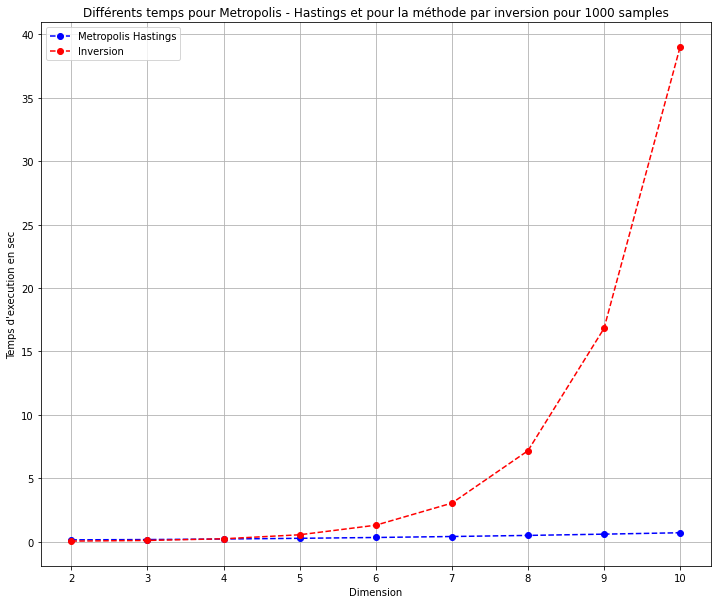

In [31]:
test_du_temps(10,1000)

## Les distributions obtenues avec les 2 méthodes 

Les 2 méthodes permettent d'obtenir la distribution souhaitée avec $\beta$ et $\gamma$ fixés.  

In [32]:
beta = [2,1]
d = 2
gamma = [[10,-1],[5,1]]
n=10000

x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_MH = np.array(metropolis_hastings_avec_iter(beta, gamma, x0,10, n,True,False))

df_MH=pd.DataFrame(samples_MH, columns=['state_nb'])


samples= np.array(generate_data( beta, d, gamma,n,True))
df=pd.DataFrame(samples, columns=['state_nb'])

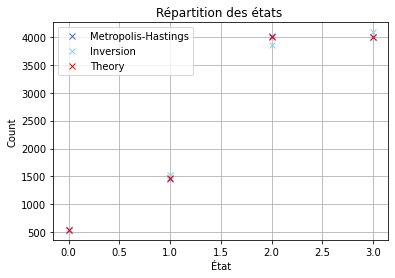

In [33]:
empirical_distrib_MH = list(df_MH.groupby(by='state_nb')['state_nb'].count())
empirical_distrib_I = list(df.groupby(by='state_nb')['state_nb'].count())
theorical_distrib = proba_theorique(beta, d, gamma)*n 


fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(2**d)], empirical_distrib_MH, 'x'
                ,color='royalblue', label='Metropolis-Hastings')
rects2= ax.plot([i for i in range(2**d)], empirical_distrib_I, 'x'
                ,color='skyblue',  label='Inversion')
rects3= ax.plot([i for i in range(2**d)], theorical_distrib
                ,'rx' , label= 'Theory')
#plt.legend('Revenue', 'Budget')
plt.title('Répartition des états ')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()
plt.show()

# Question 2 : 
### How is α related to the other parameters? What particular problem does this quantity pose if one wishes to estimate the parameters of this model (based on data) ? 

$ \alpha $ peut être vue comme un coefficient de normalisation : elle est liée à la "probabilité de l'état nul", 
> i.e. la probabilité $P(X=[0,...,0])= e^{\alpha}$

Elle est reliée aux autres paramètres $\beta$  et $\gamma$  qui correspondent aux coefficients des variables explicatives $X_i$ et $X_iX_j$ respectivement.

En effet en sommant sur tous les états possibles, c'est à dire les $2^d$ états possibles, et en utilisant le fait que la somme des probabilités sur tous les états est égale à 1, on obtient :

>>> ### $ e^{-\alpha} = \sum_{i \in \{0,1\}^d } e^{\sum_{i=1 }^d \beta _i x_i}   e^{\sum_{i=1}^d \sum_{j=i+1}^d \gamma _{ij} x_i x_j}   $


- Le problème avec $e^{\alpha}$ est qu'il s'agit de la constante de normalisation. En effet, tout se passe comme si on avait : 
> $ P(X=x) = e^{\alpha} e^{\sum_{i=1 }^d \beta _i x_i}   e^{\sum_{i=1}^d \sum_{j=i+1}^d \gamma _{ij} x_i x_j} $ 

> i.e. $ P(X=x) = \frac{e^{\sum_{i=1 }^d \beta _i x_i}   e^{\sum_{i=1}^d \sum_{j=i+1}^d \gamma _{ij} x_i x_j}}{e^{-\alpha}} $

Néanmoins, cette dernière s'avère compliquée à calculer car $\textbf{assez long à calculer}$ .
D'autre part, $\alpha$ est non identifiable, c'est-à-dire qu'il existe plusieurs ensembles de valeurs pour les paramètres $\beta$ et $\gamma$ qui donnent la même valeur de $\alpha$. 
Par exemple en dimension 2 : 
- $\beta = (0,1)$ et $\gamma = -1$ 
- $\beta = (0,0)$ et $\gamma = 1 $ 


Cela peut rendre l'estimation des autres paramètres difficile.

# Question 3

# The Exchange Algorithm

Comme présenté dans l'article, l'objectif ici n'est pas de simuler une distribution étant donnés des paramètres mais plus exactement de remonter aux paramètres étant donnée une distribution. Autrement dit, l'objectif est de remonter aux paramètres $\beta$ et $\gamma$ du log-linear model en observant des données $y$. 

La constante de normalisation $ \mathcal{Z(\theta)}$ mentionnée dans l'article s'avère être $ e^{-\alpha}$ de la question précédente. 

L'exchange algorithm est commenté ci-dessous. 

In [8]:
# Les fonctions sont les mêmes que précédemment SAUF que le gamma est maintenant un vecteur tel que i<j et non plus une matrice. 
# Gamma est de taille d*(d-1)/2

def log_f_bis(x, beta, gamma):
    " On calcule la log-proba pour un vecteur fixé étant donnés les paramètres (on n'a pas besoin de alpha puisqu'on utilise un rapport dans l'algo M-H)"
    d = len(x)
    linear_terms=0
    pairwise=0
    count=0
    for i in range(d):
        linear_terms+= beta[i]*x[i]
        for j in range(i+1,d):
            pairwise += gamma[count] * x[i] * x[j]
            count+=1

    return linear_terms + pairwise

def proba_non_normalisée_bis(x,beta,gamma):
    return(np.exp(log_f_bis(x, beta, gamma)))

def metropolis_hastings_avec_iter_bis(beta, gamma, initial_state,nb_iter, n, binary_form, plot_acceptance_rate):
    "On génère n samples avec le log-linear model en utilisant l'algo de Metropolis Hastings" 
    d=len(beta)
    samples = np.zeros((n, d)) #vecteurs de 0 
    current_state = initial_state #état initial
    acceptance_rate_moyen=[]
    for i in range(n): #pour chacun des vecteurs 
        acceptance_rate=0
        for t in range(nb_iter):
            j = np.random.randint(0, len(beta)) # on change une composante au hasard
            x_proposed = np.copy(current_state)
            x_proposed[j] = 1 - x_proposed[j]
            new_state = np.copy(current_state)
            new_state[j] = 1 - current_state[j] # on propose un nouvel état en modifiant la j-ième composante
            a = log_f_bis(new_state, beta, gamma) - log_f_bis(current_state, beta, gamma) # on calcule le rapport des probabilités entre le nouvel état et l'ancien état
            a = min(1, np.exp(a)) # car g(x|x')= g(x'|x)
            acceptance_rate+=a
            if np.random.uniform() < a: # on fait le choix d'accepter ou de rejeter 
                current_state = new_state
        samples[i] = current_state
        
    if binary_form==True:
        samples= [binary_transf(i) for i in samples]

    if plot_acceptance_rate == True : 
        fig, ax = plt.subplots(figsize=(6,4))
        rects1= ax.plot([i for i in range(n)], acceptance_rate_moyen
                        ,'rx')
        #plt.legend('Revenue', 'Budget')
        plt.title('Acceptance Rate avec Metropolis - Hastings pour les 10 itérations')
        plt.legend(loc='best')
        plt.xlabel("Nombre d'échantillons") 
        plt.ylabel("Acceptance Rate Moyen ")
        plt.grid()
        
        
    return samples

La fonction `exchange_alg` prend en arguments un dataframe d'observations binaires (i.e. dans $\{0,1\}^d$), la dimension $d$ ainsi que le nombre d'itérations. Il renvoie les paramètres estimés $\beta$ et $\gamma$. 

Voici le déroulement de l'algorithme: 

> 0. On initialise $\theta = (\beta , \gamma)$ cela revient à initialiser d'un côté $\beta$ et de l'autre $\gamma$. 

Pour chacune des itérations : 
> 1. On propose un nouveau $\theta '= (\beta' , \gamma')$ en le tirant suivant $q(\theta ' | \theta , y)$. Nous avons choisi une loi normale centrée en $\theta$ : $\mathcal{N}(\theta, cov_{fixée})$
> 2. On génère une variable auxiliaire $w$ qui est en réalité un data set de la même taille que $y$ telle que :
 $w$  ~  $\frac{f(w|\theta ')}{\mathcal{Z(\theta ')}} $ 
 Pour cela, on utilise l'algorithme de `Metropolis-Hastings` de la question 1. en utilisant les nouveaux paramètres $\theta '$ 
> 3. On calcule le rapport d'acceptation à l'aide de la fonction `fonction_alpha` : 
$a = \frac{q(\theta | \theta ', y) p(\theta ') f(y | \theta') f(w| \theta)}{q(\theta' | \theta, y) p(\theta) f(y | \theta) f(w| \theta')} $
> 4. On tire une uniforme dans [0,1] :
$r$  ~  $\mathcal{U}([0,1]) $
> 5. Si $r < a$ alors on remplace l'ancien $\theta$ par $\theta '$ car cela signifie que ce dernier "colle mieux" aux données $y$ que l'ancien. 
    


In [9]:
def fonction_alpha(beta,beta_bis,gamma,gamma_bis,y,w):
    " fonction qui renvoie le rapport a de l'algorithme Single Variable Exchange Algorithm "
    a=1
    for i in range(len(y)):
        a*= proba_non_normalisée_bis(y[i],beta_bis,gamma_bis) * proba_non_normalisée_bis(w[i],beta,gamma)/(proba_non_normalisée_bis(y[i],beta,gamma)* proba_non_normalisée_bis(w[i],beta_bis,gamma_bis))     
    return(a)

In [10]:
def exchange_alg(y, d, num_iterations):
    count=0
    acceptance_rate=[]

    cov_beta= np.identity(d)/1000
    cov_gamma = np.identity(int(d*(d-1)/2))/1000

    beta = np.random.multivariate_normal(np.zeros((1, d))[0], cov_beta, size=1)
    gamma = np.random.multivariate_normal(np.zeros((1, int(d*(d-1)/2)))[0], cov_gamma, size=1)

    beta = beta[0]
    gamma = gamma[0]

    #ne concerne que le cas ou d=2 pour afficher l'évolution des paramètres
    evolution_beta0=[beta[0]]
    evolution_beta1=[beta[1]]
    evolution_gamma=[gamma[0]]

    print(beta, gamma)
    for t in tqdm(range(num_iterations)):
        
        beta_bis = np.random.multivariate_normal(beta, cov_beta, size=1) # il s'agit de notre q(theta'|theta,y) comme dans l'article 
        gamma_bis = np.random.multivariate_normal(gamma, cov_gamma, size=1)

        beta_bis = beta_bis[0]
        gamma_bis = gamma_bis[0]

        #ne concerne que le cas ou d=2 pour afficher l'évolution des paramètres
        evolution_beta0.append(beta_bis[0])
        evolution_beta1.append(beta_bis[1])
        evolution_gamma.append(gamma_bis[0])

        
        x0 = np.zeros(len(beta), dtype=int)  # état initial
        w = np.array(metropolis_hastings_avec_iter_bis(beta_bis, gamma_bis, x0, 3, len(y),False,False)) # w est un dataset de même taille que y 

        a=fonction_alpha(beta,beta_bis,gamma,gamma_bis,y,w)
        a=min(1,a)
        acceptance_rate.append(a)
        r= np.random.uniform()
        if r < a: # on fait le choix d'accepter ou de rejeter 
            count+=1
            beta,gamma = beta_bis,gamma_bis
    print(count)
    print(beta,gamma)

    #si la dimension est égale à 2, on renvoie l'évolution des beta et gamma avec les itérations en plus de beta et gamma et acceptance rate
    if d==2: 
        return(beta, gamma, acceptance_rate, evolution_beta0, evolution_beta1, evolution_gamma)
    else: 
        return(beta, gamma, acceptance_rate)

# Mesure de l'erreur d'estimation des paramètres

On va utiliser 3 métriques différentes : 
- MSE : Mean Squared Error : $\text{MSE}_{\beta} = \frac{1}{n} \sum_{i=1}^n (\beta _i - \hat{\beta}_i)^2$

- RMSE : Root Mean Squared Error : $\text{RMSE}_{\beta} = \sqrt{\frac{1}{n} \sum_{i=1}^n (\beta _i - \hat{\beta}_i)^2}$

- MAE : Mean Absolute Error : $\text{MAE}_{\beta} = \frac{1}{n} \sum_{i=1}^n \left|\beta _i  - \hat{\beta}_i \right|$

In [159]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [160]:
def mesure_erreur_parametre(beta_theorique,gamma_theorique, beta_exchange,gamma_exchange):

    erreur_mse_beta=mean_squared_error(beta_theorique,beta_exchange)
    erreur_mse_gamma=mean_squared_error(gamma_theorique,gamma_exchange)

    erreur_rmse_beta=mean_squared_error(beta_theorique,beta_exchange, squared=False)
    erreur_rmse_gamma=mean_squared_error(gamma_theorique,gamma_exchange, squared=False)

    erreur_mae_beta=mean_absolute_error(beta_theorique,beta_exchange)
    erreur_mae_gamma=mean_absolute_error(gamma_theorique,gamma_exchange)

    print("MSE Beta")
    print(erreur_mse_beta)
    print("MSE Gamma")
    print(erreur_mse_gamma)

    print("RMSE Beta")
    print(erreur_rmse_beta)
    print("RMSE Gamma")
    print(erreur_rmse_gamma)

    print("MAE Beta")
    print(erreur_mae_beta)
    print("MAE Gamma")
    print(erreur_mae_gamma)

    theta_theorique = np.concatenate((beta_theorique, gamma_theorique))
    theta_exchange = np.concatenate((beta_exchange, gamma_exchange))

    erreur_mse_theta=mean_squared_error(theta_theorique,theta_exchange)
    erreur_rmse_theta=mean_squared_error(theta_theorique,theta_exchange, squared=False)
    erreur_mae_theta=mean_absolute_error(theta_theorique,theta_exchange)

    print("MSE Theta")
    print(erreur_mse_theta)

    print("RMSE Theta")
    print(erreur_rmse_theta)
    
    print("MAE Theta")
    print(erreur_mae_theta)

In [11]:
# Cette fonction a pour but de comparer 2 distributions
def display_distrib_comparison(samples_empirique,samples_originaux,d):
    df_1=pd.DataFrame(samples_originaux, columns=['state_nb'])
    samples_originaux = list(df_1.groupby(by='state_nb')['state_nb'].count())

    df_2=pd.DataFrame(samples_empirique, columns=['state_nb'])
    samples_empirique = list(df_2.groupby(by='state_nb')['state_nb'].count())


    fig, ax = plt.subplots(figsize=(6,4))
    x = np.arange(2**d)

    ax.bar(x - 0.21, samples_originaux, width=0.4, color='royalblue', label='Distribution initiale', edgecolor = "black")
    ax.bar(x + 0.21, samples_empirique, width=0.4, color='red', label='Distribution obtenue', edgecolor = "black")

    plt.title('Comparaisons des distributions originale et simulée avec les paramètres obtenus par Exchange Algorithm ')
    plt.legend(loc='best')
    plt.xlabel("État") 
    plt.ylabel("Count")
    plt.grid()
    plt.show()

# Test en Dimension 2

Dans un premier temps, on génère des données avec des paramètres $\beta$  et $\gamma$ fixés et connus à l'aide de la question 2.
 
L'objectif est de remonter aux paramètres à partir de la distribution (obtenue par la simulation) notamment grâce à l'algorithme Exchange. 


### Premièrement on fixe les paramètres et on génère des données 

In [689]:
d=2
beta = np.random.normal(size=d)

dim_gamma= int(d*(d-1)/2)
gamma = np.random.normal(size=dim_gamma)


print("beta")
print(beta)
print("gamma")
print(gamma)

beta
[-1.2038792   1.03360541]
gamma
[0.35544313]


In [690]:
n_iter=10
n=1000

x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples = np.array(metropolis_hastings_avec_iter_bis(beta, gamma, x0, n_iter, n, False, False))

#### Distribution à partir de laquelle on estime nos paramètres : 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


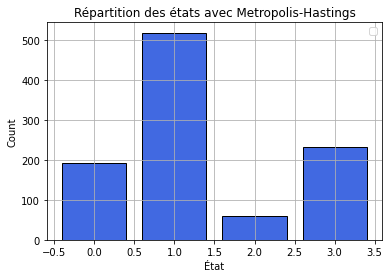

In [691]:
display_distrib([ binary_transf(i) for i in samples],d,'Metropolis-Hastings')

### Ensuite on utilise l'algorithme Exchange pour estimer les paramètres

#### Pour 500 itérations

In [692]:
num_iterations_exchange=500

b= exchange_alg(samples, d, num_iterations_exchange)

[ 0.00105176 -0.04951994] [-0.02077194]


100%|██████████| 500/500 [00:27<00:00, 18.17it/s]

317
[-1.49077215  0.86883567] [0.64793297]


In [693]:
# On fait la moyenne sur 10 essais pour 500 itérations 
beta_liste=[]
gamma_liste=[]
for i in range(10): 
    j= exchange_alg(samples, d, num_iterations_exchange)
    beta_liste.append(j[0])
    gamma_liste.append(j[1])

moyenne_colonne_beta = np.mean(beta_liste, axis=0)
moyenne_colonne_gamma = np.mean(gamma_liste, axis=0)

[-0.03424612 -0.01287005] [0.0285661]


100%|██████████| 500/500 [00:27<00:00, 18.30it/s]


332
[-0.93868634  1.00921887] [0.21166374]
[0.02831735 0.0213903 ] [0.02567474]


100%|██████████| 500/500 [00:28<00:00, 17.84it/s]


321
[-1.25657515  1.09533682] [0.28808015]
[-0.01275979  0.02333588] [-0.00584859]


100%|██████████| 500/500 [00:27<00:00, 18.04it/s]


318
[-1.00209364  1.01352015] [0.14732644]
[-0.00314849 -0.02816494] [0.03023113]


100%|██████████| 500/500 [00:28<00:00, 17.72it/s]


306
[-1.27355832  0.99987739] [0.58704633]
[0.03541998 0.0102587 ] [-0.0179508]


100%|██████████| 500/500 [00:27<00:00, 17.92it/s]


319
[-0.98490824  1.02927701] [0.23611237]
[-0.02258837 -0.04712125] [0.00013267]


100%|██████████| 500/500 [00:27<00:00, 18.03it/s]


307
[-1.15130575  1.05297399] [0.28947597]
[0.05286747 0.01395827] [0.025191]


100%|██████████| 500/500 [00:27<00:00, 18.07it/s]


293
[-1.30199811  1.02125054] [0.42811566]
[-0.04675049 -0.01077599] [-0.04107631]


100%|██████████| 500/500 [00:27<00:00, 18.03it/s]


311
[-1.10393642  1.00075978] [0.3512067]
[-0.00115898 -0.03501619] [-0.07653263]


100%|██████████| 500/500 [00:27<00:00, 18.32it/s]


333
[-1.14267481  0.9680043 ] [0.28169734]
[-0.06454146  0.05384876] [0.04265684]


100%|██████████| 500/500 [00:27<00:00, 18.32it/s]

306
[-1.12321249  1.06711081] [0.27698521]


In [694]:
print("beta")
print(moyenne_colonne_beta)
print("gamma")
print(moyenne_colonne_gamma)

beta
[-1.12789493  1.02573297]
gamma
[0.30977099]


### Affichage des boxplots dans l'estimation des paramètres 

beta
[-1.2038792   1.03360541]
gamma
[0.35544313]


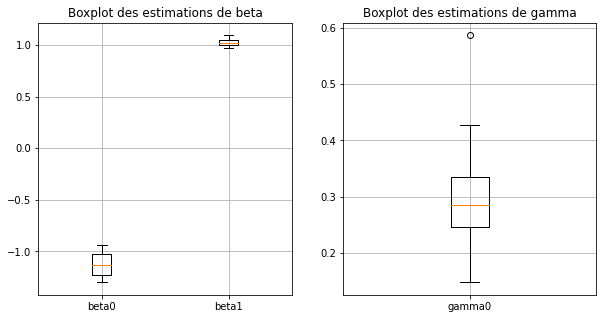

In [695]:
def display_boxplot_dim2(beta_liste,gamma_liste):
    # extraire chaque colonne
    beta_liste= np.array(beta_liste)
    gamma_liste= np.array(gamma_liste)

    beta0 = beta_liste[:, 0]
    beta1 = beta_liste[:, 1]
    gamma0 = gamma_liste[:]

    gamma0 = gamma_liste[:, 0]

    # créer un boxplot pour chaque coefficient
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.grid()
    ax1.boxplot([beta0, beta1])
    ax2.grid()
    ax2.boxplot([gamma0])

    # ajouter des étiquettes d'axe
    ax1.set_xticklabels(['beta0', 'beta1'])
    ax2.set_xticklabels(['gamma0'])


    # ajouter des titres
    ax1.set_title('Boxplot des estimations de beta')
    ax2.set_title('Boxplot des estimations de gamma')

print("beta")
print(beta)
print("gamma")
print(gamma)
display_boxplot_dim2(beta_liste,gamma_liste)

#### Pour 1000 itérations

In [708]:
num_iterations_exchange=1000

c= exchange_alg(samples, d, num_iterations_exchange)

[-0.0296016  -0.00548551] [-0.01437394]


100%|██████████| 1000/1000 [00:55<00:00, 18.01it/s]

640
[-1.20413525  1.01742194] [0.38592938]


In [697]:
# On fait la moyenne sur 10 essais pour 1000 itérations 
beta_liste=[]
gamma_liste=[]
for i in range(10): 
    j= exchange_alg(samples, d, num_iterations_exchange)
    beta_liste.append(j[0])
    gamma_liste.append(j[1])

moyenne_colonne_beta = np.mean(beta_liste, axis=0)
moyenne_colonne_gamma = np.mean(gamma_liste, axis=0)

[-0.01036737 -0.00211928] [-0.00657585]


100%|██████████| 1000/1000 [00:54<00:00, 18.43it/s]


635
[-1.18619977  0.89920032] [0.46305249]
[ 0.04278318 -0.00222197] [0.04661498]


100%|██████████| 1000/1000 [00:54<00:00, 18.42it/s]


633
[-1.06901522  1.03431984] [0.28959927]
[0.00154815 0.01885912] [-0.04635187]


100%|██████████| 1000/1000 [00:55<00:00, 18.15it/s]


624
[-1.40901592  0.97514751] [0.55547951]
[-0.0021897   0.00917308] [0.01999335]


100%|██████████| 1000/1000 [00:55<00:00, 17.98it/s]


642
[-1.22108356  1.00655482] [0.42555547]
[ 0.03842132 -0.01027592] [-0.02286831]


100%|██████████| 1000/1000 [00:54<00:00, 18.21it/s]


645
[-1.32022157  0.92402113] [0.46748323]
[0.00459082 0.01396498] [0.00342084]


100%|██████████| 1000/1000 [00:54<00:00, 18.31it/s]


654
[-1.09401314  1.11413647] [0.27624416]
[-0.02776997 -0.01690033] [0.00975572]


100%|██████████| 1000/1000 [00:54<00:00, 18.38it/s]


642
[-1.19673354  1.01297202] [0.53420805]
[-0.00241699  0.00603058] [0.03216443]


100%|██████████| 1000/1000 [00:54<00:00, 18.36it/s]


651
[-1.05861402  0.92222938] [0.11888776]
[ 0.02453365 -0.03175267] [0.03728314]


100%|██████████| 1000/1000 [00:54<00:00, 18.43it/s]


639
[-1.09164441  1.21613042] [0.23731427]
[-0.01769528 -0.01061718] [0.02477408]


100%|██████████| 1000/1000 [00:54<00:00, 18.33it/s]

638
[-1.16248028  1.03851321] [0.3945439]


beta
[-1.2038792   1.03360541]
gamma
[0.35544313]


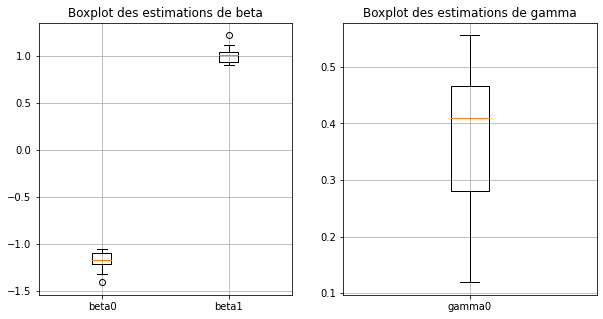

In [698]:
print("beta")
print(beta)
print("gamma")
print(gamma)
display_boxplot_dim2(beta_liste,gamma_liste)

#### Pour 10 000 itérations 

In [709]:
num_iterations_exchange=10000

e= exchange_alg(samples, d, num_iterations_exchange)

[-0.04053245 -0.02206897] [0.01453367]


100%|██████████| 10000/10000 [09:08<00:00, 18.25it/s]

6476
[-1.32674624  0.97427584] [0.61952714]


### Distribution obtenue avec les paramètres estimés par Exchange algorithm
#### On génère des data avec les paramètres obtenus dans l'espoir de retrouver la distribution que nous avions simulée :

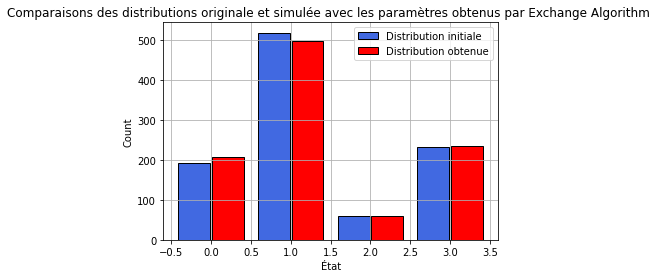

In [700]:
d=2
x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_b = np.array(metropolis_hastings_avec_iter_bis(b[0], b[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_b = [ binary_transf(i) for i in samples_b]
y = [ binary_transf(i) for i in samples]
display_distrib_comparison(samples_b,y,d)

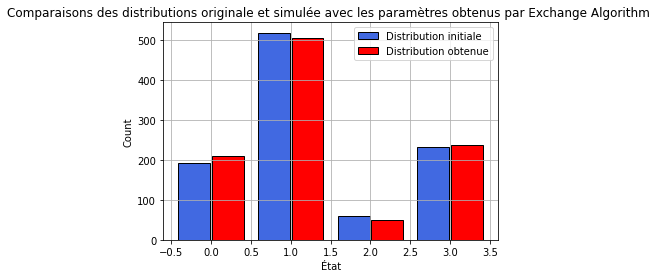

In [701]:
x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_c = np.array(metropolis_hastings_avec_iter_bis(c[0], c[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_c = [ binary_transf(i) for i in samples_c]
display_distrib_comparison(samples_c,y,d)

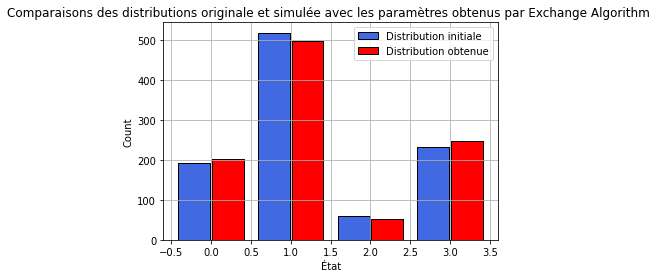

In [702]:
x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_e = np.array(metropolis_hastings_avec_iter_bis(e[0], e[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_e = [ binary_transf(i) for i in samples_e]
display_distrib_comparison(samples_e,y,d)

### Affichage de l'évolution des paramètres dans Exchange 

Valeurs théoriques
beta
[-1.2038792   1.03360541]
gamma
[0.35544313]


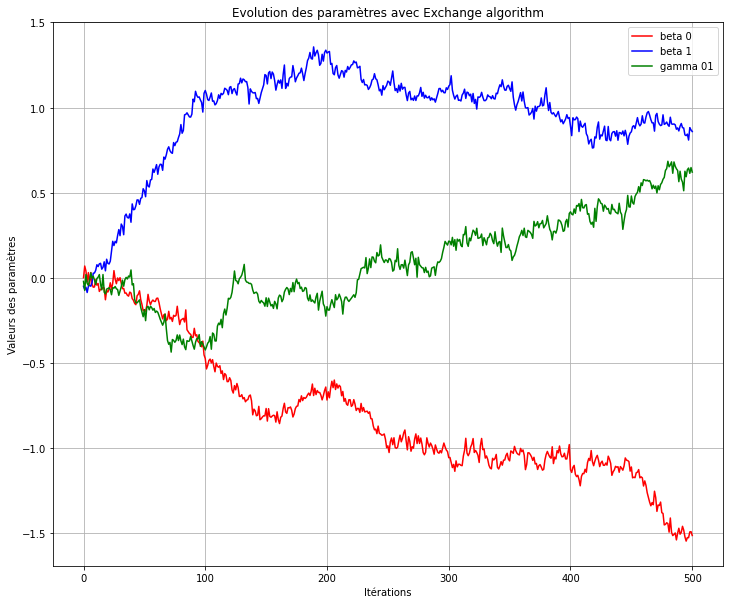

In [710]:
num_iterations_exchange=500

print("Valeurs théoriques")
print("beta")
print(beta)
print("gamma")
print(gamma)


fig, ax = plt.subplots(figsize=(12,10))
rects1= ax.plot([i for i in range(num_iterations_exchange+1)], b[3]
                ,'r-', label='beta 0')
rects2= ax.plot([i for i in range(num_iterations_exchange+1)], b[4]
                ,'b-', label='beta 1')
rects3= ax.plot([i for i in range(num_iterations_exchange+1)], b[5]
                ,'g-', label='gamma 01')



plt.title('Evolution des paramètres avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("Itérations") 
plt.ylabel("Valeurs des paramètres")
plt.grid()

Valeurs théoriques
beta
[-1.2038792   1.03360541]
gamma
[0.35544313]


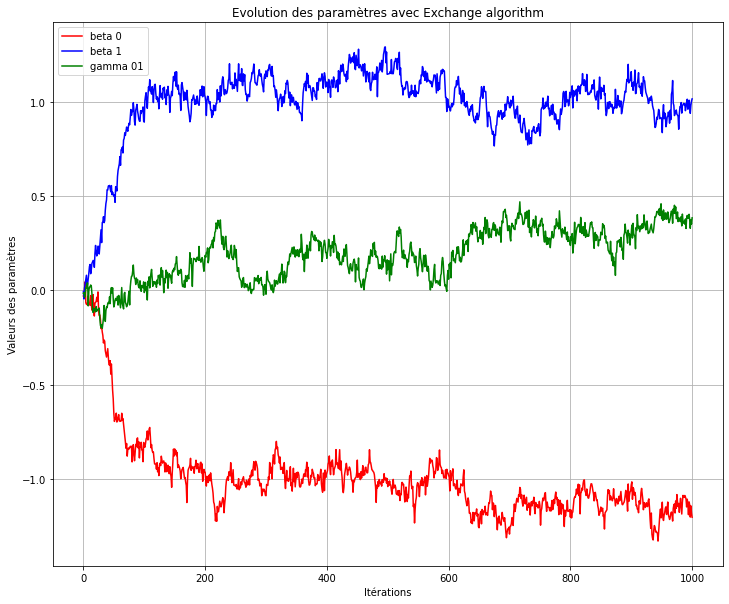

In [711]:
num_iterations_exchange=1000

print("Valeurs théoriques")
print("beta")
print(beta)
print("gamma")
print(gamma)


fig, ax = plt.subplots(figsize=(12,10))
rects1= ax.plot([i for i in range(num_iterations_exchange+1)], c[3]
                ,'r-', label='beta 0')
rects2= ax.plot([i for i in range(num_iterations_exchange+1)], c[4]
                ,'b-', label='beta 1')
rects3= ax.plot([i for i in range(num_iterations_exchange+1)], c[5]
                ,'g-', label='gamma 01')



plt.title('Evolution des paramètres avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("Itérations") 
plt.ylabel("Valeurs des paramètres")
plt.grid()

Valeurs théoriques
beta
[-1.2038792   1.03360541]
gamma
[0.35544313]


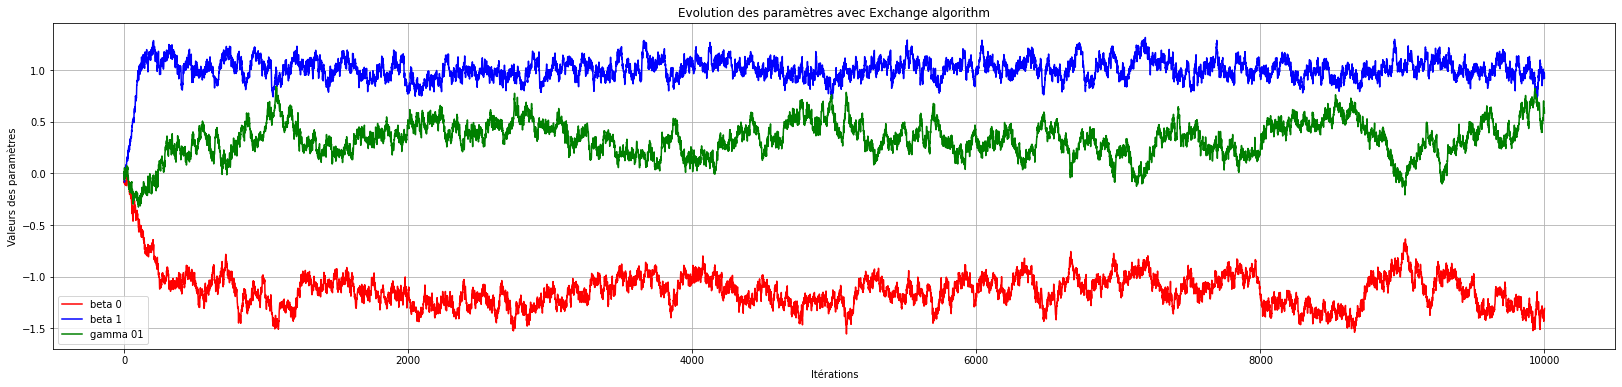

In [712]:
num_iterations_exchange=10000

print("Valeurs théoriques")
print("beta")
print(beta)
print("gamma")
print(gamma)


fig, ax = plt.subplots(figsize=(28,6))
rects1= ax.plot([i for i in range(num_iterations_exchange+1)], e[3]
                ,'r', label='beta 0')
rects2= ax.plot([i for i in range(num_iterations_exchange+1)], e[4]
                ,'b', label='beta 1')
rects3= ax.plot([i for i in range(num_iterations_exchange+1)], e[5]
                ,'g', label='gamma 01')



plt.title('Evolution des paramètres avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("Itérations") 
plt.ylabel("Valeurs des paramètres")
plt.grid()

### Erreurs d'estimation 

In [713]:
print('500 itérations')
mesure_erreur_parametre(beta,gamma, list(b[0]),list(b[1]))

500 itérations
MSE Beta
0.05472831803102988
MSE Gamma
0.08555030392126946
RMSE Beta
0.2339408430159853
RMSE Gamma
0.2924898355862464
MAE Beta
0.22583134944030947
MAE Gamma
0.2924898355862464
MSE Theta
0.06500231332777641
RMSE Theta
0.2549555124483023
MAE Theta
0.24805084482228845


In [714]:
print('1000 itérations')
mesure_erreur_parametre(beta,gamma, list(c[0]),list(c[1]))

1000 itérations
MSE Beta
0.0001309851149373355
MSE Gamma
0.0009294112436833802
RMSE Beta
0.01144487286680527
RMSE Gamma
0.030486246795618843
MAE Beta
0.008219760967693723
MAE Gamma
0.030486246795618843
MSE Theta
0.00039712715785268377
RMSE Theta
0.019928049524544137
MAE Theta
0.01564192291033543


In [715]:
print('10000 itérations')
mesure_erreur_parametre(beta,gamma, list(e[0]),list(e[1]))

10000 itérations
MSE Beta
0.009308153954932757
MSE Gamma
0.0697403646488586
RMSE Beta
0.09647877463428293
RMSE Gamma
0.26408401058916575
MAE Beta
0.09109830600714819
MAE Gamma
0.26408401058916575
MSE Theta
0.029452224186241372
RMSE Theta
0.1716165032455835
MAE Theta
0.14876020753448738


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


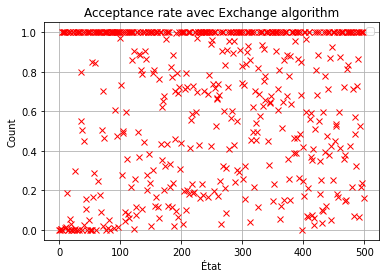

In [716]:
fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(len(b[2]))], b[2]
                ,'rx')

plt.title('Acceptance rate avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


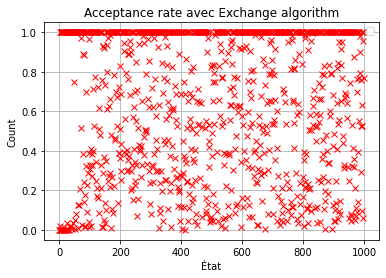

In [717]:
fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(len(c[2]))], c[2]
                ,'rx')

plt.title('Acceptance rate avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


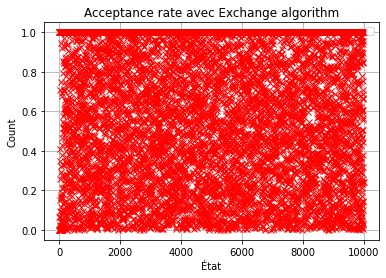

In [718]:
fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(len(e[2]))], e[2]
                ,'rx')

plt.title('Acceptance rate avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()

# Test en dimension 3

In [634]:
d=3
beta = np.random.normal(size=d)

dim_gamma= int(d*(d-1)/2)
gamma = np.random.normal(size=dim_gamma)


print("beta")
print(beta)
print("gamma")
print(gamma)

beta
[-0.39388097 -0.55000868  0.84564661]
gamma
[ 1.33848708 -1.17066725  0.50559813]


In [635]:
n_iter=10
n=1000

x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples = np.array(metropolis_hastings_avec_iter_bis(beta, gamma, x0, n_iter, n, False, False))
samples

array([[0., 0., 0.],
       [1., 0., 1.],
       [1., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 1.],
       [0., 0., 1.]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


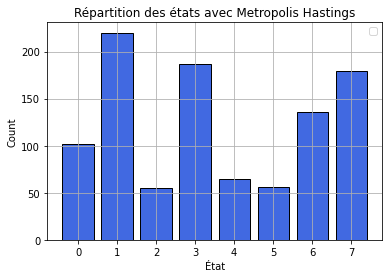

In [636]:
display_distrib([ binary_transf(i) for i in samples],d, "Metropolis Hastings")

In [658]:
num_iterations_exchange=500

b= exchange_alg(samples, d, num_iterations_exchange)

[ 0.03983727 -0.04205864 -0.03455978] [ 0.02379288 -0.0271906  -0.01560913]


100%|██████████| 500/500 [00:33<00:00, 14.76it/s]

244
[-0.29698061 -0.41261304  0.82057619] [ 1.1421113  -1.01371145  0.37712782]


In [652]:
num_iterations_exchange=1000

c= exchange_alg(samples, d, num_iterations_exchange)

[-0.09671153 -0.00487952  0.00861998] [ 0.06154746 -0.01972765  0.00697779]


100%|██████████| 1000/1000 [01:08<00:00, 14.52it/s]

453
[-0.37023987 -0.56952057  0.88134625] [ 1.24650288 -1.08470964  0.44665275]


In [639]:
# On fait la moyenne sur 10 essais pour 500 itérations 
beta_liste=[]
gamma_liste=[]
for i in range(10): 
    j= exchange_alg(samples, d, 500)
    beta_liste.append(j[0])
    gamma_liste.append(j[1])

moyenne_colonne_beta = np.mean(beta_liste, axis=0)
moyenne_colonne_gamma = np.mean(gamma_liste, axis=0)

[ 0.01762017  0.0346549  -0.01115544] [ 0.02679856  0.02251382 -0.0260132 ]


100%|██████████| 500/500 [00:34<00:00, 14.70it/s]


249
[-0.31715055 -0.51157996  0.81006626] [ 1.13463013 -0.87810251  0.35383694]
[-0.02075253  0.03770254 -0.01293087] [ 0.01443567  0.01288565 -0.03510348]


100%|██████████| 500/500 [00:34<00:00, 14.65it/s]


257
[-0.52470657 -0.58149409  0.79942377] [ 1.29746857 -0.77550159  0.28136016]
[-0.02066166 -0.01267291  0.0207893 ] [-0.05940458  0.026867    0.02809933]


100%|██████████| 500/500 [00:34<00:00, 14.65it/s]


246
[-0.2532296  -0.58929175  0.88459929] [ 1.30247177 -1.04531988  0.42150854]
[ 0.04232683 -0.02220766 -0.03703823] [ 0.0436816  -0.00882753 -0.02117948]


100%|██████████| 500/500 [00:34<00:00, 14.68it/s]


232
[-0.17101174 -0.55027472  0.84734226] [ 1.23931555 -1.19401295  0.5877062 ]
[0.05836477 0.01072868 0.00456286] [-0.0318999   0.01593574  0.01042563]


100%|██████████| 500/500 [00:34<00:00, 14.65it/s]


221
[-0.37108545 -0.56706891  1.05036396] [ 1.40852675 -1.16266786  0.25083004]
[-0.05238843 -0.00206374 -0.04482908] [-0.02045428 -0.01577237 -0.07452701]


100%|██████████| 500/500 [00:34<00:00, 14.49it/s]


226
[-0.28036477 -0.713883    0.86361862] [ 1.36371969 -1.03690699  0.47734654]
[-0.01816321 -0.02292641 -0.03215676] [ 0.06008003 -0.04942624 -0.01816631]


100%|██████████| 500/500 [00:35<00:00, 14.19it/s]


249
[-0.04202909 -0.7786956   0.8444571 ] [ 1.18512612 -1.12646718  0.51855644]
[ 0.01385973 -0.00724676 -0.01922033] [-0.00376144  0.02581402 -0.00926567]


100%|██████████| 500/500 [00:34<00:00, 14.41it/s]


237
[-0.3039414  -0.55094853  0.76355847] [ 1.18469319 -0.91087248  0.36671024]
[-0.01160562 -0.00521358 -0.00861302] [0.03016744 0.05366388 0.00834661]


100%|██████████| 500/500 [00:34<00:00, 14.53it/s]


243
[-0.45299881 -0.67163341  0.68399258] [ 1.39659799 -0.80126363  0.42583491]
[-0.04762648 -0.01099711 -0.00612229] [ 0.01967333  0.02781644 -0.06117212]


100%|██████████| 500/500 [00:34<00:00, 14.59it/s]

258
[-0.45133576 -0.44733472  0.8275436 ] [ 1.10911852 -0.82057717  0.21389531]


beta
[-0.39388097 -0.55000868  0.84564661]
gamma
[ 1.33848708 -1.17066725  0.50559813]


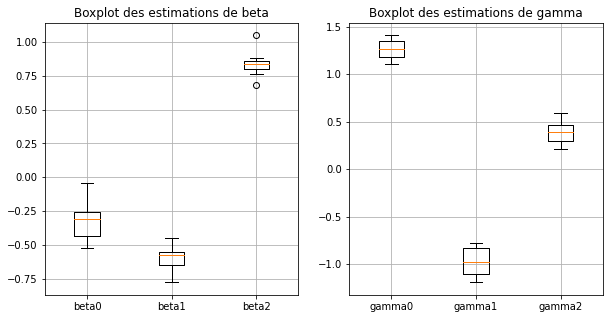

In [640]:
def display_boxplot_dim3(beta_liste,gamma_liste):
    # extraire chaque colonne
    beta_liste= np.array(beta_liste)
    gamma_liste= np.array(gamma_liste)

    beta0 = beta_liste[:, 0]
    beta1 = beta_liste[:, 1]
    beta2 = beta_liste[:, 2]

    gamma0 = gamma_liste[:,0] #correspond au gamma_01
    gamma1 = gamma_liste[:,1] #correspond au gamma_02
    gamma2 = gamma_liste[:,2] #correspont au gamma_12
    

    # créer un boxplot pour chaque coefficient
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.grid()
    ax1.boxplot([beta0, beta1,beta2])
    ax2.grid()
    ax2.boxplot([gamma0,gamma1,gamma2])

    # ajouter des étiquettes d'axe
    ax1.set_xticklabels(['beta0', 'beta1','beta2'])
    ax2.set_xticklabels(['gamma0','gamma1','gamma2'])


    # ajouter des titres
    ax1.set_title('Boxplot des estimations de beta')
    ax2.set_title('Boxplot des estimations de gamma')

print("beta")
print(beta)
print("gamma")
print(gamma)
display_boxplot_dim3(beta_liste,gamma_liste)

In [641]:
num_iterations_exchange=5000

e= exchange_alg(samples, d, num_iterations_exchange)

[-0.02005193  0.04643257 -0.01319557] [ 0.06649485  0.0287138  -0.00522251]


100%|██████████| 5000/5000 [05:43<00:00, 14.55it/s]

2378
[-0.56838155 -0.69297182  0.75022568] [ 1.23374099 -0.79020829  0.41743176]


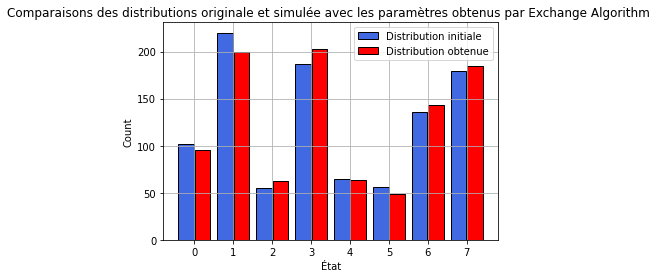

In [659]:
x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_b = np.array(metropolis_hastings_avec_iter_bis(b[0], b[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_b = [ binary_transf(i) for i in samples_b]
y = [ binary_transf(i) for i in samples]
display_distrib_comparison(samples_b,y,d)

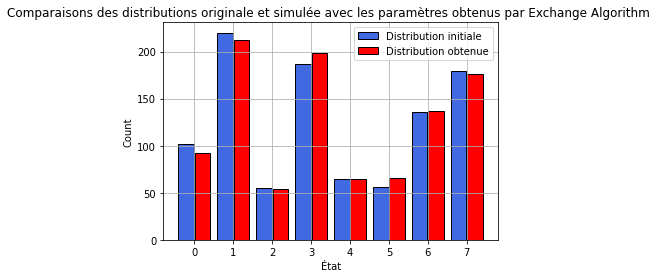

In [679]:
x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_c = np.array(metropolis_hastings_avec_iter_bis(c[0], c[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_c = [ binary_transf(i) for i in samples_c]
display_distrib_comparison(samples_c,y,d)

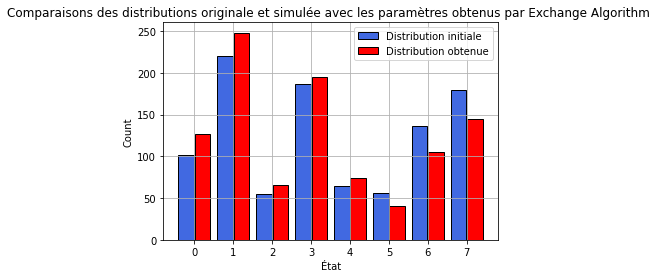

In [665]:
x0 = np.zeros(len(beta), dtype=int)  # start from all zeros
samples_e = np.array(metropolis_hastings_avec_iter_bis(e[0], e[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_e = [ binary_transf(i) for i in samples_e]
display_distrib_comparison(samples_e,y,d)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


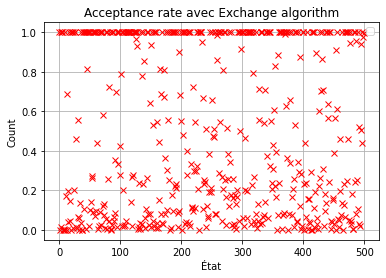

In [666]:
fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(500)], b[2]
                ,'rx')

plt.title('Acceptance rate avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


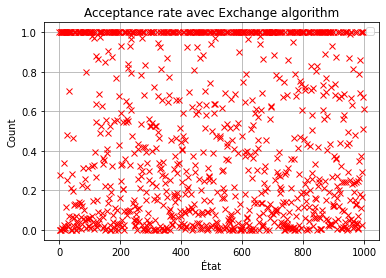

In [667]:
fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(1000)], c[2]
                ,'rx')

plt.title('Acceptance rate avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


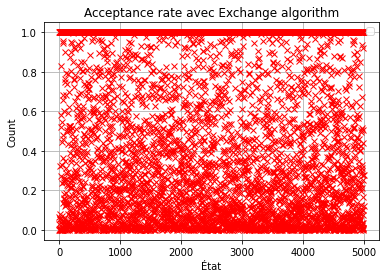

In [668]:
fig, ax = plt.subplots(figsize=(6,4))
rects1= ax.plot([i for i in range(5000)], e[2]
                ,'rx')

plt.title('Acceptance rate avec Exchange algorithm')
plt.legend(loc='best')
plt.xlabel("État") 
plt.ylabel("Count")
plt.grid()

In [669]:
print('500 itérations')
mesure_erreur_parametre(beta,gamma, list(b[0]),list(b[1]))

500 itérations
MSE Beta
0.009631922726502032
MSE Gamma
0.02656772894635356
RMSE Beta
0.09814235949121068
RMSE Gamma
0.1629961010158021
MAE Beta
0.08645547433942073
MAE Gamma
0.16060062640913472
MSE Theta
0.018099825836427795
RMSE Theta
0.13453559319536149
MAE Theta
0.12352805037427772


In [670]:
print('1000 itérations')
mesure_erreur_parametre(beta,gamma, list(c[0]),list(c[1]))

1000 itérations
MSE Beta
0.0007380264042843201
MSE Gamma
0.006441453054554964
RMSE Beta
0.02716664138763421
RMSE Gamma
0.08025866342367635
MAE Beta
0.026284207434401557
MAE Gamma
0.0789623914085888
MSE Theta
0.0035897397294196412
RMSE Theta
0.059914436736229454
MAE Theta
0.05262329942149518


In [671]:
print('5000 itérations')
mesure_erreur_parametre(beta,gamma, list(e[0]),list(e[1]))

5000 itérations
MSE Beta
0.019998022148342013
MSE Gamma
0.054498023220890056
RMSE Beta
0.14141436330282017
RMSE Gamma
0.23344811676449664
MAE Beta
0.13762821847208076
MAE Gamma
0.19112380227047265
MSE Theta
0.03724802268461603
RMSE Theta
0.19299746807825233
MAE Theta
0.1643760103712767


####  On peut également utiliser cet algorithme pour des plus grandes dimensions $d$

# Question 4 : Application aux données du Titanic 

### Chargement des données

In [12]:
titanic_df = pd.read_csv('https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv')

titanic_df.head()

,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


### On cherche quelles sont les variables binaires

In [13]:
titanic_df.describe()

,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


In [14]:
titanic_df['Siblings/Spouses Aboard']= titanic_df['Siblings/Spouses Aboard'].apply(lambda x : 1 if x>0 else 0)
titanic_df['Sex']= titanic_df['Sex'].apply(lambda x : 1 if x=="female" else 0)
titanic_df['Survived']= titanic_df['Survived'].apply(lambda x : int(x))

In [15]:
titanic_df['Sex'].value_counts()

0    573
1    314
Name: Sex, dtype: int64

In [16]:
# On sélectionne les variables binaires 
variables_binaires= ['Survived','Siblings/Spouses Aboard','Sex']

Les variables binaires choisies sont le fait de survivre `Survived`, le fait d'avoir des proches sur le bateau `Siblings/Spouses Aboard` ainsi que le sexe `Sex`.

In [17]:
d=len(variables_binaires)
num_iterations_exchange=1000

samples=titanic_df[variables_binaires].copy()
samples

,Survived,Siblings/Spouses Aboard,Sex
0,0,1,0
1,1,1,1
2,1,0,1
3,1,1,1
4,0,0,0
...,...,...,...
882,0,0,0
883,1,0,1
884,0,1,1
885,1,0,0


In [18]:
d=len(variables_binaires)
samples['binary_state'] = samples.apply(binary_transf,axis=1)
samples['binary_state']

0      2
1      7
2      5
3      7
4      0
      ..
882    0
883    5
884    3
885    4
886    0
Name: binary_state, Length: 887, dtype: int64

In [19]:
samples

,Survived,Siblings/Spouses Aboard,Sex,binary_state
0,0,1,0,2
1,1,1,1,7
2,1,0,1,5
3,1,1,1,7
4,0,0,0,0
...,...,...,...,...
882,0,0,0,0
883,1,0,1,5
884,0,1,1,3
885,1,0,0,4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


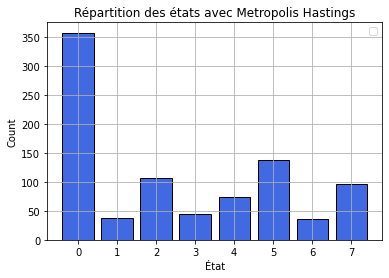

In [20]:
display_distrib([int(i) for i in samples['binary_state']],d, "Metropolis Hastings")

In [23]:
num_iterations_exchange=1000
y=[int(i) for i in samples['binary_state']] #on stock les états 
y=[np.array([int(b) for b in np.binary_repr(i, width=d)]) for i in y ] #on repasse en vecteur binaire 
c= exchange_alg(y, d, num_iterations_exchange) # on applique l'algo de Exchange 

[-0.0226552   0.00183264  0.00262379] [0.01972085 0.03826001 0.06037269]


100%|██████████| 1000/1000 [01:01<00:00, 16.39it/s]

531
[-1.22377063 -1.1763632  -2.37353055] [-0.33809301  2.57066909  1.33247786]


In [24]:
# On fait la moyenne sur 10 essais pour 500 itérations 
beta_liste=[]
gamma_liste=[]
for i in range(10): 
    j= exchange_alg(y, d, 1000)
    beta_liste.append(j[0])
    gamma_liste.append(j[1])

moyenne_colonne_beta = np.mean(beta_liste, axis=0)
moyenne_colonne_gamma = np.mean(gamma_liste, axis=0)

[ 0.03308816 -0.00588089 -0.02193881] [0.02371326 0.0032297  0.02007803]


100%|██████████| 1000/1000 [01:01<00:00, 16.31it/s]


531
[-1.19835196 -1.02680788 -2.21474954] [-0.39915326  2.49805758  1.04752462]
[ 0.00606328 -0.01101764 -0.03924106] [ 0.01370168 -0.00752452  0.04181378]


100%|██████████| 1000/1000 [01:02<00:00, 16.05it/s]


544
[-1.43293552 -1.13285969 -1.91884211] [0.02771802 2.48460538 0.76932414]
[-0.01501248 -0.02071139 -0.05260139] [ 0.00328969  0.00737633 -0.01619328]


100%|██████████| 1000/1000 [01:03<00:00, 15.78it/s]


534
[-1.56490438 -1.32877651 -1.99660872] [0.47324129 2.45462216 0.81525458]
[ 0.00944087 -0.02434396 -0.03771551] [-0.02844782 -0.04273019 -0.06506053]


100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


497
[-1.64017345 -1.17436097 -2.17715006] [0.02753279 2.7166285  0.87668631]
[0.03376551 0.00551813 0.01975525] [-0.0101062  -0.03920426  0.0095045 ]


100%|██████████| 1000/1000 [01:01<00:00, 16.39it/s]


510
[-1.3250057  -0.95737486 -2.07090565] [-0.08220974  2.72445436  0.69696955]
[-0.00375434 -0.01303925  0.00041163] [-0.02376262  0.03010719 -0.03082548]


100%|██████████| 1000/1000 [01:01<00:00, 16.20it/s]


511
[-1.59092291 -1.17066395 -1.99609332] [0.43301248 2.47643451 0.84285582]
[0.01528471 0.01878273 0.0477234 ] [ 0.05704742 -0.00212812 -0.02248987]


100%|██████████| 1000/1000 [01:00<00:00, 16.53it/s]


542
[-1.44940729 -1.1433064  -1.90453518] [0.20048689 2.19827615 0.95773482]
[-0.06767079 -0.0176929   0.00027082] [-0.02003029 -0.00334509 -0.02756813]


100%|██████████| 1000/1000 [01:01<00:00, 16.16it/s]


556
[-1.82570815 -0.98337708 -2.04543707] [0.26456311 2.76562959 0.65069161]
[-0.00428017  0.00512153 -0.02491684] [ 0.03553128 -0.04242055  0.05872807]


100%|██████████| 1000/1000 [01:01<00:00, 16.33it/s]


531
[-1.48651232 -1.05353544 -1.89762636] [-0.01634585  2.34401315  0.97315188]
[ 0.03305666  0.03074318 -0.0102645 ] [-0.00517118 -0.0060951  -0.00187846]


100%|██████████| 1000/1000 [01:01<00:00, 16.36it/s]

560
[-1.35567497 -1.05374188 -1.93049614] [-0.10888292  2.49445567  0.62224936]


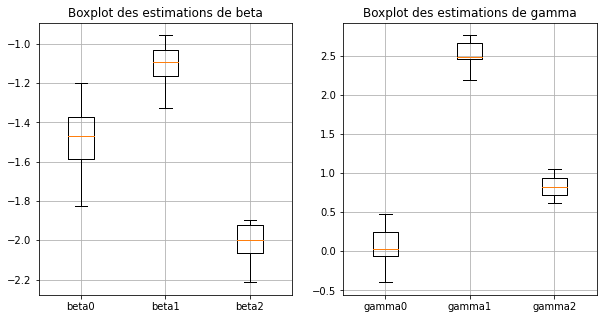

In [26]:
def display_boxplot_dim3(beta_liste,gamma_liste):
    # extraire chaque colonne
    beta_liste= np.array(beta_liste)
    gamma_liste= np.array(gamma_liste)

    beta0 = beta_liste[:, 0]
    beta1 = beta_liste[:, 1]
    beta2 = beta_liste[:, 2]

    gamma0 = gamma_liste[:,0] #correspond au gamma_01
    gamma1 = gamma_liste[:,1] #correspond au gamma_02
    gamma2 = gamma_liste[:,2] #correspont au gamma_12
    

    # créer un boxplot pour chaque coefficient
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.grid()
    ax1.boxplot([beta0, beta1,beta2])
    ax2.grid()
    ax2.boxplot([gamma0,gamma1,gamma2])

    # ajouter des étiquettes d'axe
    ax1.set_xticklabels(['beta0', 'beta1','beta2'])
    ax2.set_xticklabels(['gamma0','gamma1','gamma2'])


    # ajouter des titres
    ax1.set_title('Boxplot des estimations de beta')
    ax2.set_title('Boxplot des estimations de gamma')

display_boxplot_dim3(beta_liste,gamma_liste)

> ### On retrouve bien une distribution qui semble similaire à celle du dataset 

In [761]:
y= [ binary_transf(i) for i in y]

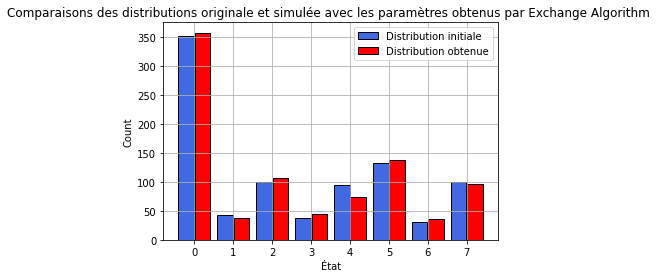

In [762]:
# Distribution obtenue avec les paramètres de Exchange Algorithm
n= len(samples)
x0 = np.zeros(d, dtype=int)  # start from all zeros
samples_empirique = np.array(metropolis_hastings_avec_iter_bis(c[0], c[1], x0, n_iter, n, False, False)) #on remplace beta et gamma par les valeurs obtenues avec Exchange Algorithm
samples_empirique= [ binary_transf(i) for i in samples_empirique]
samples_originaux= y
display_distrib_comparison(samples_originaux,samples_empirique,d)